# PRÁCTICA 4 - APRENDIZAJE PROFUNDO - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

# JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

# Sound Classification using Deep Learning


![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)
#### Mount Google Drive


Realización de la práctica centrada en clasificación de sonidos (en el dataset UrbanSound8k) utilizando deep learning

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a new folder in your drive and change to that directory as: 
# /content/drive/My_Drive/new_dir_that_you_just_created_for_this_lab
import os
os.chdir('/content/drive/MyDrive/Master Inteligencia Artificial Aplicada - UCIIIM/p4DL/Dataset')

#### Required Python libraries for the lab session
You may need to install librosa using pip as follows:
!pip install librosa==0.8.0


In [ ]:
# Importamos las librerías necesarias para el desarrollo de la práctica

import os
import sys
import pickle
import copy

from datetime import datetime
from tqdm import tqdm

import librosa
import librosa.display
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

## [!] INSTRUCTIONS FOR THE SUBMISSION OF THE LAB EXERCISES

The objective of this activity is that the student strengthens the concepts about Sound Classification using CNNs and LSTMs.

In order to do the lab session exercises, the student has to use Google Colab, execute this notebook for its resolution and answer several brief questions, including both extra code and text cells, if necessary. 

Lab exercises will be done individually, never in groups.

**YOU CAN WORK IN GROUPS UP TO THREE PEOPLE. THE DEADLINE TO SEND THIS LAB IS DUE 31/12/2022 AT 23:59H**

---

Estableceremos una clasificación de sonidos usando CNNs y LSTMs

# LAB SESSION 4
---

# Sound Classificaton with CNN-RNNs

### APPLICATIONS OF SPEECH, AUDIO, IMAGE AND VIDEO PROCESSING

### MASTER EN IA APLICADA
### ACADEMIC COURSE 2022/2023

1. OBJECTIVE
2. DATABASE
3. READING AUDIO FILES AND FEATURE EXTRACTION
4. LOADING THE PRECOMPUTED FEATURES
5. DATA AUGMENTATION
6. UTILITY FUNCTIONS
7. CNN-RNN MODEL
8. SPLITTING AND NORMALIZING THE DATA
9. TRAINING AND TESTING THE SYSTEM

NOTE: you will find sections in this notebook called exercises, which are the ones you are expected to report for evaluation.

---
## 1. OBJECTIVE 
---
The objective of this lab exercise is to implement an **environmental sound classification system based on Deep-Learning techniques**. This system takes and audio signal and provides the category to which it belongs.

The system is going to be implemented in **Pytorch** and uses log-mel spectrograms as input and **CNN-RNN** models. CNN-RNN consists of a combination of **Convolutional Neural Networks (CNNs)** and **Recursive Neural Networks (RNNs)**. In this lab, we are going to use a particular kind of RNNs, the **Long Short-Term Memory networks (LSTMs)**. 

The main idea is that, as log-mel spectrograms are two dimensional signals, they can be visualized as images, so that CNNs are adequate for extraction more complex features from them. In addition, due to the sequential nature of log-mel spectrograms, LSTMs are suitable for performing a further processing prior to the classification itself.  

For building and assessing the system we are going to use urban sound excerpts from the **UrbanSound8K dataset**.

In this script, it is assumed that the audio database has been downloaded and the corresponding features have been generated in advance (see the script *LabSession2 - Sound Classfication - Preprocessing.ipynb* in Aula Global). 



Como objetivo buscamos implementar un sistema de clasificación de sonidos usando técnicas asociadas al ámbito de Deep Learning. El sistema toma una señal de audio y te devuelve la categoria/etiqueta a la que pertenece.

La entrada será los valores en dB del espectograma de las señales de audio (valores que, al ser en 2D (tiempo-frecuencia) pueden representarse como imágenes y ser la entrada a una CNN) (las cuales tendrán todas la misma longitud ya que se limitan a 3 segundos) y se clasificarán usando una CNN combinada consecutivamente con una RNN, más especificamente una LSTM.

De esta manera, las complejas características de los espectrogramas serán extraidas por una CNN y facilitarán la tarea de clasificación a la LSTM.

Como sabemos usaremos el dataset UrbanSound8K preprocesado.

---
## 2. DATABASE
---
The database used in this lab session is the [UrbanSound8k dataset](https://urbansounddataset.weebly.com/urbansound8k.html) that contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes:

* air_conditioner
* car_horn
* children_playing
* dog_bark
* drilling
* enginge_idling
* gun_shot
* jackhammer
* siren
* street_music

This audio dataset is located in the directory *UrbanSound8K/audio/*.


Todo explicado en el scrip de preprocesamiento de los audios.

---
## 3. READING AUDIO FILES AND FEATURE EXTRACTION
---

The following code shows an example of reading an audio file with the function **load** from the *librosa* library. Note that the sampling frequency of the audio file is 22050 Hz.

Sampling rate = 22050 Hz
Length of the audio signal = 66150 samples


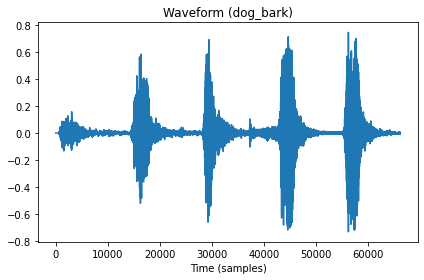

In [ ]:
# READING AUDIO FILES

# Reading an audio file from the database
SOUND_DURATION = 3.0    # fixed duration of an audio excerpt in seconds

audio_file = 'UrbanSound8K/audio/fold2/100652-3-0-0.wav';
audio, sampling_rate = librosa.load(audio_file, duration=SOUND_DURATION, res_type='kaiser_fast') # Cargamos el audio (las muestras en orden de tiempo dada la frecuencia de muestreo) del path indicado con el tiempo indicado (y la frecuencia de muestreo del mismo)
print('Sampling rate =', sampling_rate, 'Hz')
print('Length of the audio signal =', len(audio), 'samples')

# Plot the audio signal. It corresponds to the category 'dog_bark'
# Con esto ploteamos el audio (el valor de sus muestras) a lo largo del tiempo
fig, ax = plt.subplots()
plt.plot(audio)
plt.title('Waveform (dog_bark)')
ax.set_xlabel('Time (samples)')
plt.tight_layout()
plt.show()

# Ponemos el audio para que pueda ser reproducido y escuchado
# Play the audio data
ipd.Audio(audio, rate=sampling_rate)

De esta forma tomamos, el audio en forma de muestras (con una longitud asociada a SOUND_DURATION), la frecuencia de muestreo del mismo, ploteamos la señal y la dejamos para poder reproducirla

Vemos como los audio son simplemente sus muestras tomadas en función a la frecuencia de muestreo

In [ ]:
audio

array([0.        , 0.        , 0.        , ..., 0.00074983, 0.00196061,
       0.00331628], dtype=float32)

In [ ]:
len(audio)/sampling_rate # Si una muestra se toma en 1/fs s, ¿cuantos s se tarda en tomar todas las muestras que tenemos?

3.0

Obviamente son 3s ya que limitamos los audios a esta duración

Con la siguiente función creamos el espectograma (en dB) del audio anterior. A la función le pasamos el audio, la fs... (ojo, el hop_length y el window_length se introduce en muestras (se puede hacer el equivalente en tiempo al saber la fs). 

El cambio es: seconds = samples/sr = samples/22050 (nuestra fs)

The following code computes the log-mel spectrogram of the previous audio file considering the following configuration:

* Frame period or hop length = 512 samples (512 / 22050 = 23.25 ms)
* Size (length) of the analysis window = 1024 samples (1024 / 22050 = 46.5 ms)
* Number of filters in the mel filterbank = 128

For the log-mel spectrogram computation, we have used the function **melspectrogram** from the module *feature* of the *librosa* package. This function has, among others, the following input arguments:

* y: speech signal 
* sr: sampling frequency
* hop_length: frame period or hop length (in samples)
* win_length: window size (in samples)
* n_mels: number of filters in the mel filterbank

Note that in this function the window size and the hop length must be expressed in samples. Taking into account that the sampling frequency (sr) indicates that 1 second corresponds to sr samples (in our case, as sr = 22050 Hz, 1 second corresponds to 22050 samples), the conversion from **samples** to **seconds** is performed by:

```
seconds = samples/sr = samples/22050
```


Dimensions of the log-mel spectrogram before the crop/padding process = 128 130
Dimensions of the log-mel spectrogram after the crop/padding process = 128 128


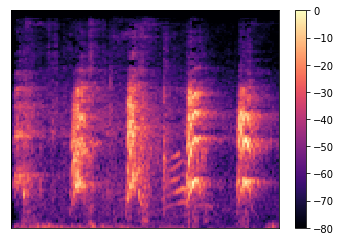

In [ ]:
# FEATURE EXTRACTION

# Extract the log-mel spectrogram of the audio file. This spectrogram is forced
# to have a fixed length that is determined by the configuration variable
# NUM_OF_FRAMES. Sequences longer than this quantity are cut, whereas
# sequences shorter than this quantity are padded at the beginning and the
# end with a predefined constant value.

# Configuration variables for log-mel spectrogram computation
WINDOW_LENGTH = 1024  # length of the analysis window in samples
HOP_LENGTH = 512      # number of samples between successive frames (frame period or hop length)
N_MEL = 128           # number of Mel bands to generate
NUM_OF_FRAMES = 128   # fixed duration in frames

# Mel spectrogram computation # Obtenemos el espectograma
melspectrogram = librosa.feature.melspectrogram(y=audio, 
                                                sr=sampling_rate, 
                                                hop_length=HOP_LENGTH,
                                                win_length=WINDOW_LENGTH, 
                                                n_mels=N_MEL)

# Convert the power spectrogram to decibel units (log-mel spectrogram)
# Pasamos los valores del espectograma de power a dB
melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)

freq_dimension = melspectrogram_db.shape[0]
time_dimension = melspectrogram_db.shape[1]
print('Dimensions of the log-mel spectrogram before the crop/padding process =', freq_dimension, time_dimension)

# Pad or fix the length of spectrogram 
if time_dimension != NUM_OF_FRAMES:
    melspectrogram_db = librosa.util.fix_length(melspectrogram_db, 
                                                size=NUM_OF_FRAMES, 
                                                axis=1, 
                                                constant_values=(-80.0, -80.0))
    
freq_dimension = melspectrogram_db.shape[0]  # number of mel bands 
time_dimension = melspectrogram_db.shape[1]  # length of the spectrogram
print('Dimensions of the log-mel spectrogram after the crop/padding process =', freq_dimension, time_dimension)

# Dibujamos el espectograma
# Plot the log-mel spectrogram. It corresponds to the category 'dog_bark'
plt.figure()
librosa.display.specshow(melspectrogram_db)
plt.colorbar()


---
## 4. LOADING THE PRECOMPUTED FEATURES
---

The script *LabSession4 - Sound Classfication - Preprocessing.ipynb* (available in Aula Global) performs the previously described processes (database download and feature extraction) for the whole database.

After the execution of this script, you should find in your Google Drive directory the following items:

*   A directory called *UrbanSound8k* that contains the speech files in wav format
*   A zip file called *us8k_features.pkl* that contains the corresponding features (log-mel spectrograms)

As at this point, we do not need the audio files, in the following step we will only load the feature file *us8k_features.pkl*.

Also a custom dataset class for the management of this data is created.


Una vez preprocesados los audios (cosa que ya hicimos en el script anterior) obtendremos solo el pkl generado con los valores del espectograma de cada audio junto a su etiqueta/label/categoria y la carpeta en la que se encuentra.

In [ ]:
# LOADING THE PRECOMPUTED FEATURES
us8k_df = pd.read_pickle("us8k_features.pkl")
us8k_df.head()

,melspectrogram,label,fold
0,"[[-66.802155, -71.387344, -65.72824, -72.96362...",3,5
1,"[[-14.977399, -5.958457, -12.821328, -16.38356...",2,5
2,"[[-20.648745, -18.456596, -6.6629195, -12.4990...",2,5
3,"[[-15.8254175, -14.34151, -16.916325, -15.5090...",2,5
4,"[[-10.893131, -3.303463, -8.647091, -11.555508...",2,5


In [ ]:
len(us8k_df['melspectrogram'][0][0])

128

Cada uno de los audios tiene 128 bandas con 128 frames dentro de estas

In [ ]:
# CUSTOM DATASET CLASS

DEFAULT_SAMPLE_RATE = 22050

class UrbanSound8kDataset(Dataset):
    def __init__(self, us8k_df, transform=None):
        assert isinstance(us8k_df, pd.DataFrame)
        assert len(us8k_df.columns) == 3

        self.us8k_df = us8k_df
        self.transform = transform

    def __len__(self):
        return len(self.us8k_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        spectrogram, label, fold = self.us8k_df.iloc[index]

        if self.transform is not None:
            spectrogram = self.transform(spectrogram)

        return {'spectrogram': spectrogram, 'label':label}

---
## 5. DATA AUGMENTATION
---

To compensate for the relatively small size of the dataset, two **data augmentation** techniques are used. Data augmentation is performed online by applying the techniques on the input log-mel spectrograms before they are fed to the model. Both techniques are applied with given probabilities, ensuring that the model is rarely trained on the exact same examples. Although this approach is much more time consuming, the effects of overfitting are significantly reduced.

The two main techniques used for the purposes of this lab exercise are:

* **Time Shifting**
* **Background Gaussian Noise**

The following code implements these transformations

Para compensar tener un dataset relativamente pequeño (10 clases en unas 8k muestras) usaremos dos técnicas de "data augmentation".  Estas técnica se aplican las dos seguidas en linea a los datos de entrada al modelo (los espectogramas de los audios) antes de que entren al mismo. 

Ambas técnicas se aplican (o no) en función de una determinada probabilidad (para cada uno de los datos) de esta manera el modelo (en cada loop de entrenamiento) se entrenará (fijandonos en la misma muestra) con diferentes versiones de la misma muestra, aumentando el "tamaño" del dataset.

Si bien esto aumenta el gasto computacional reduce drásticamente los efectos del overfitting.

Se introducen dos técnicas de "data augmentation":
  -Time shifting
  - Background Gaussian Noise

In [ ]:
# TRANSFORMATIONS

class MyRightShift(object):
    """Shift the image to the right in time."""

    def __init__(self, input_size, width_shift_range, shift_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(width_shift_range, (int, float))
        assert isinstance(shift_probability, (float))

        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        if isinstance(width_shift_range, int):
            assert width_shift_range > 0
            assert width_shift_range <= self.input_size[1]
            self.width_shift_range = width_shift_range
        else:
            assert width_shift_range > 0.0
            assert width_shift_range <= 1.0
            self.width_shift_range = int(width_shift_range * self.input_size[1])
                        
        assert shift_probability > 0.0 and shift_probability <= 1.0
        self.shift_prob = shift_probability

    def __call__(self, image):
        if np.random.random() > self.shift_prob:
          return image

        # create a new array filled with the min value
        shifted_image= np.full(self.input_size, np.min(image), dtype='float32')

        # randomly choose a start postion
        rand_position = np.random.randint(1, self.width_shift_range)

        # shift the image
        shifted_image[:,rand_position:] = copy.deepcopy(image[:,:-rand_position])

        return shifted_image

class MyAddGaussNoise(object):
    """Add Gaussian noise to the spectrogram image."""

    def __init__(self, input_size, mean=0.0, std=None, add_noise_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(mean, (int, float))
        assert isinstance(std, (int, float)) or std is None
        assert isinstance(add_noise_probability, (float))


        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        self.mean = mean

        if std is not None:
            assert std > 0.0
            self.std = std
        else:
            self.std = std

        assert add_noise_probability > 0.0 and add_noise_probability <= 1.0
        self.add_noise_prob = add_noise_probability


    def __call__(self, spectrogram):
      if np.random.random() > self.add_noise_prob:
          return spectrogram

      # set some std value 
      min_pixel_value = np.min(spectrogram)
      if self.std is None:
        std_factor = 0.03     # factor number 
        std = np.abs(min_pixel_value*std_factor)

      # generate a white noise spectrogram
      gauss_mask = np.random.normal(self.mean, 
                                    std, 
                                    size=self.input_size).astype('float32')
      
      # add white noise to the sound spectrogram
      noisy_spectrogram = spectrogram + gauss_mask

      return noisy_spectrogram

class MyReshape(object):
    """Reshape the image array."""

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))

        self.output_size = output_size

    def __call__(self, image):
      return image.reshape(self.output_size)


# build transformation pipelines for data augmentation
train_transforms = transforms.Compose([MyRightShift(input_size=128, 
                                                    width_shift_range=13, 
                                                    shift_probability=0.9),
                                       MyAddGaussNoise(input_size=128,
                                                       add_noise_probability=0.55),
                                       MyReshape(output_size=(1,128,128))])

test_transforms = transforms.Compose([MyReshape(output_size=(1,128,128))])


# Este es el pipeline de data augmentation. Los datos de entrenamiento entraran por aquí antes de pasar al modelo; se les aplicará
# rigtshift con una prob del 90%y  gaussianoise con una prob del 55%

# Finalmente se les aplicará (y esto también a los datos de test) un reshape a imagen de 128x128 para que todas tengan el mismo tamaño (necesario para establecer la arquitectura de la CNN)


---
### **[EXERCISE 1]**
---

Answer the following questions:

1. Explain the data augmentation mechanism implemented in this class (*MyRightShift* and *MyAddGaussNoise* functions). What would you listen by playing the augmented samples in comparison with the original ones?

MyRightShift es un tipo de "data augmentation" en audio que implica desplazar el audio en tiempo hacia la derecha. Con esto podemos simular cambios en el entorno donde se grabó dicho audio como cambios en la posición del micrófono, variación de la distancia entre el objeto o ser que genera el audio y el micrófono que lo graba o incluso generar efectos de eco y rever en el propio audio. Al escuchar un audio al que se le aplica esta técnica percibiremos exactamente el mismo audio pero como si hubiese sigo grabado "x" segundos más tarde. 

MyAddGaussNoise implica añadir ruido gaussiano a los audios. Como sabemos, el ruido gaussiano es un tipo de ruido aleatorio que sigue una distribución normal. Con esta técnica podemos ayudar a que el modelo obtenga patrones y características de los audios a pesar de la presencia del ruido, simulando un escenario mucho más realista y parecido al mundo donde los audios, generalmente, viene afectado por ruido. Al escuchar un audio al que se le aplica esta técnica percibiremos el audio como tal, acompañado de un leve (o no tan leve) ruido estático

2. As you can see, there is another transformation implemented in this class (*MyReshape*). What is the purpose of this transformation?  

La clase "MyReshape" se usa para hacer un "reshape" de una imagen proporcionada. Se puede utilizar en el "pipeline" de data augmentation para ir dando diferentes outputs (en tamaño) a una imagen de manera que el modelo aprenda patrones de esta que son independientes al tamaño de la misma imagen. Sin embargo, en este caso, creo que se usará para aplicarlo a todas las imágenes de espectogramas y así tener un tamaño fijo de input a la entrada de la CNN (lo cual es necesario).

---
## 6. UTILITY FUNCTIONS
---

There are two additional helper functions:

* *normalize_data*: it normalizes the data to zero mean and unit variance using the corresponding statistics of the training data

* *show_results*: it plots accuracy and loss values obtained during the training process

In [ ]:
# UTILITY FUNCTIONS

def normalize_data(train_df, test_df):
    # compute the mean and std (pixel-wise)
    mean = train_df['melspectrogram'].mean()
    std = np.std(np.stack(train_df['melspectrogram']), axis=0)

    # normalize train set
    train_spectrograms = (np.stack(train_df['melspectrogram']) - mean) / std
    train_labels = train_df['label'].to_numpy()
    train_folds = train_df['fold'].to_numpy()
    train_df = pd.DataFrame(zip(train_spectrograms, train_labels, train_folds), columns=['melspectrogram', 'label', 'fold'])

    # normalize test set
    test_spectrograms = (np.stack(test_df['melspectrogram']) - mean) / std
    test_labels = test_df['label'].to_numpy()
    test_folds = test_df['fold'].to_numpy()
    test_df = pd.DataFrame(zip(test_spectrograms, test_labels, test_folds), columns=['melspectrogram', 'label', 'fold'])

    return train_df, test_df

def show_results(history):
    """Show accuracy and loss graphs for train and test sets."""

    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.grid(linestyle='--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid(linestyle='--')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
            
    plt.show()

    print('\tMax validation accuracy: %.4f %%' % (np.max(history['val_accuracy']) * 100))
    print('\tMin validation loss: %.5f' % np.min(history['val_loss']))



Usamos dos funciones extra; Una para normalizar los valores (media 0, std 1) y otra para plotear valores de loss y accuracy durante el entrenamiento.

## 7. CNN-RNN MODEL
---

The general architecture of the CNN-RNN model can be seen in the next Figure.

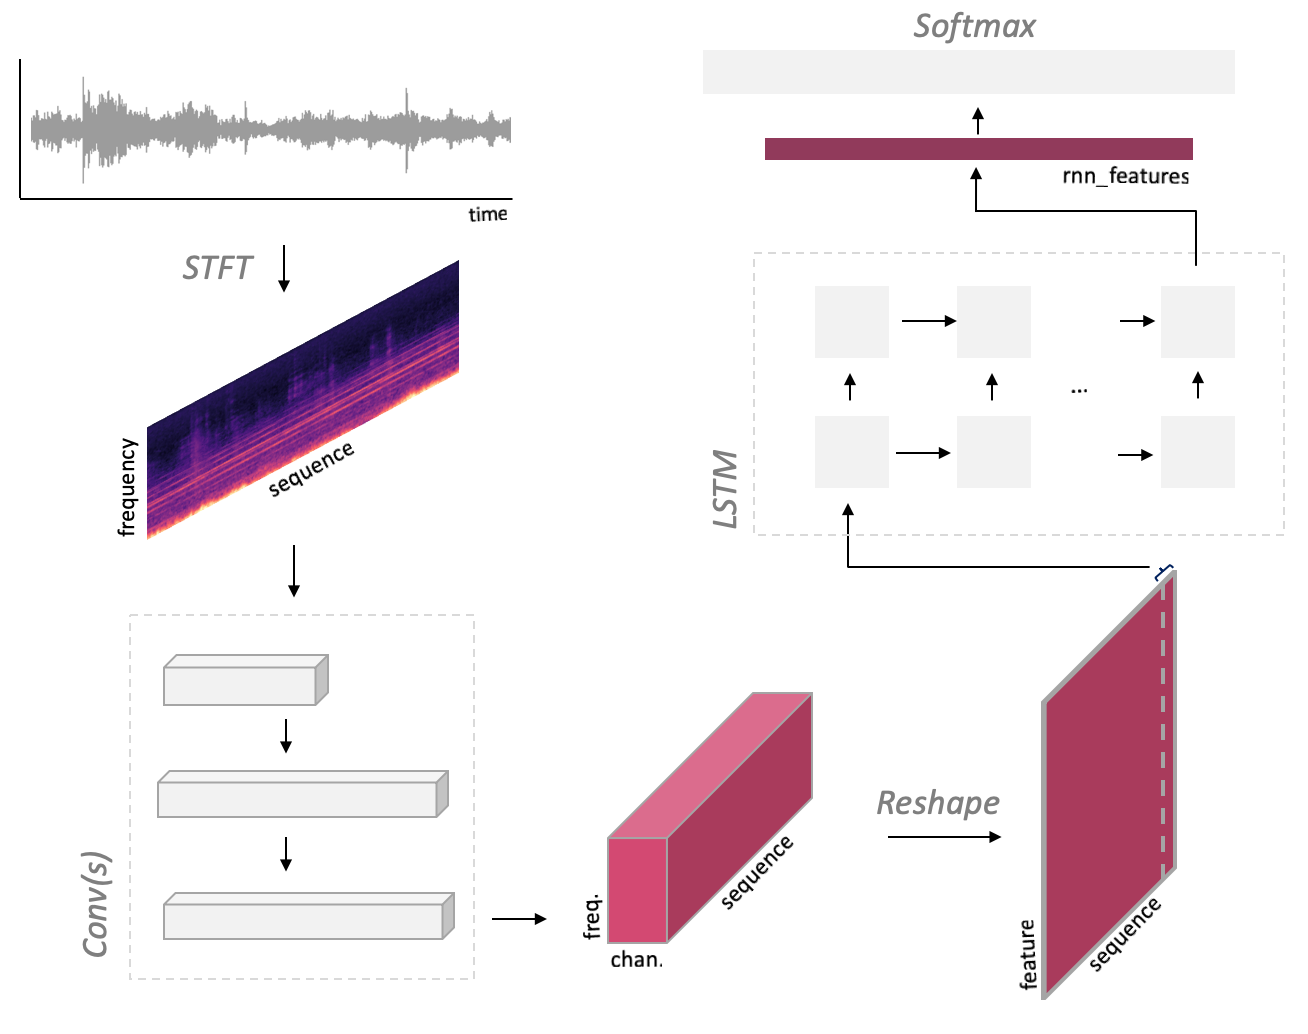

This is a general overview of the complete model:

1. The log-mel spectrogram is passed through a CNN that computes visual features for different time instants. At this point, a time instant is a bunch of columns from the log-mel spectrogram image. In particular, this CNN is composed of three CNN layers, with 32, 64 and 64 filters, respectively.

2. The visual features of each audio excerpt are reshaped and used as a sequence in a LSTM network composed of *hidden_size_rnn* nodes and *num_layers_rnn* layers. Note that LSTM node refers to the number of features in the hidden state.

3. As sound classification is a Many-to-One problem, only the last frames of the output of each of the LSTM nodes are retained. 

4. The classifier itself is composed by a linear layer with *num_classes* output units, followed by a softmax activation function.

The following class implements this model together to the **train** and **evaluate** methods.




Tenemos la señal en el tiempo, la pasamos a imagen en forma de espectograma. Eso entrará a una CNN la cual nos da importantes features del mismo en diferentes instantes del tiempo. Estas features se reshapean para usarlas como secuencia en una red LSTM; a su salida se pasa el estado oculto a una capa lineal con 10 unidades de salida (ya que tenemos 10 clases) aplicando una softmax para la clasificación.

In [ ]:
# CNN-RNN MODEL

class CNN_RNN(nn.Module):
    def __init__(self, hidden_size_rnn, num_layers_rnn, num_classes, device):
        super(CNN_RNN, self).__init__()

        self.convs1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )
        
        self.convs3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0),
            nn.Dropout(p=0.1)
        )
 
        self.recur = nn.LSTM(128, hidden_size_rnn, num_layers=num_layers_rnn, batch_first=True)

        self.dense = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(hidden_size_rnn, eps=1e-05, momentum=0.1),
            nn.Linear(in_features=hidden_size_rnn, out_features=num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):

        # input x -> (batch, channel, freq, time)

        # cnn layer-1
        x = self.convs1(x)
        # cnn layer-2
        x = self.convs2(x)
        # cnn layer-3
        x = self.convs3(x)
        # x -> (batch, channel, freq, time)
        # transpose channel and time
        x = x.transpose(1, 3)
        # YOUR CODE HERE!!! THINK ABOUT THIS, AN LSTM WORKS IN TIME NOT CHANNELS!!!
        # x -> (batch, time, freq, channel)
        
        # collapse height and channel!!! AN LSTM EXPECTS TWO DIMENSIONS, TIME AND FEATURES
        x = x.reshape(x.size(0), x.size(1), -1)
        # xt -> (batch, time, freq*channel)

        # rnn layer 
        x, _ = self.recur(x)
        # x -> (batch, time, lstm_out)
        
        # many-to-one rnn!! We are going to only use the last time step of the rnn_layer to predict the sound
        x = x[:,-1]
        # x -> (batch, lstm_out)

        # dense output layer
        x = self.dense(x)
        # x -> (batch, num_classes)

        # Softmax activation!!!
        x = F.softmax(x)
        # x -> (batch, num_classes)
        
        return x
    
    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step() 

                    pbar.update(1)        
            
            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
        return history

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)
        self.eval()

        with torch.no_grad():
            for step, batch in enumerate(data_loader):
                X_batch = batch['spectrogram'].to(self.device)
                y_batch = batch['label'].to(self.device)
            
                outputs = self.forward(X_batch)

                # get batch loss
                loss = self.criterion(outputs, y_batch)
                running_loss = running_loss + loss

                # calculate batch accuracy
                predictions = torch.argmax(outputs, dim=1) 
                correct_predictions = (predictions == y_batch).float().sum()
                running_acc = running_acc + torch.div(correct_predictions, batch_size)
            
            loss = running_loss.item() / (step+1)
            accuracy = running_acc.item() / (step+1)
        
        return loss, accuracy


---
## 8. SPLITTING AND NORMALIZING THE DATA
---

The original database is divided into 10 different folds. In this lab exercise, we are going to use folds 3-10 for training, fold 1 for testing and fold 2 for validation.

Once the division into training, validation and testing sets is performed, the data is normalized to mean zero and variance unity with respect to the training data.

El dataset se encuentra dividido en 10 carpetas diferentes (donde, en el interior de cada una, se encuentran audios de todo tipo de etiquetas). Usaremos las carpetas 3-10 para entranmiento, la 1 para test y la 2 para validación.

In [ ]:
# SPLITTING AND NORMALIZING THE DATA

fold_k = 1
dataset_df = us8k_df

# split the data
train_df = dataset_df[dataset_df['fold'] > (fold_k+1)] # 3-10
val_df = dataset_df[dataset_df['fold'] == fold_k+1] # 2
test_df = dataset_df[dataset_df['fold'] == fold_k] # 1

# Normalizamos los datos de entrenamiento, validación y test
# normalize the data
train_df_norm, val_df_norm = normalize_data(train_df, val_df)
train_df_norm, test_df_norm = normalize_data(train_df, test_df)

---
## 9. TRAINING AND TESTING THE SYSTEM
---

The next code cell contains all the necessary to train and test the sound classification system.


Epoch 1/20
  2%|▏         | 4/218 [00:00<00:07, 27.53it/s]

<ipython-input-49-649ec3c71be2>:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


100%|██████████| 218/218 [00:08<00:00, 26.13it/s]
loss: 2.0242 - accuracy: 0.4355 - val_loss: 2.0224 - val_accuracy: 0.4542

Epoch 2/20
100%|██████████| 218/218 [00:06<00:00, 34.76it/s]
loss: 1.8645 - accuracy: 0.6072 - val_loss: 1.9387 - val_accuracy: 0.5368

Epoch 3/20
100%|██████████| 218/218 [00:06<00:00, 33.39it/s]
loss: 1.8219 - accuracy: 0.6455 - val_loss: 1.8835 - val_accuracy: 0.5982

Epoch 4/20
100%|██████████| 218/218 [00:06<00:00, 33.50it/s]
loss: 1.7501 - accuracy: 0.7170 - val_loss: 1.8869 - val_accuracy: 0.5725

Epoch 5/20
100%|██████████| 218/218 [00:07<00:00, 30.17it/s]
loss: 1.7159 - accuracy: 0.7569 - val_loss: 1.8563 - val_accuracy: 0.5960

Epoch 6/20
100%|██████████| 218/218 [00:09<00:00, 23.30it/s]
loss: 1.7281 - accuracy: 0.7417 - val_loss: 1.8494 - val_accuracy: 0.5971

Epoch 7/20
100%|██████████| 218/218 [00:09<00:00, 22.91it/s]
loss: 1.6695 - accuracy: 0.7982 - val_loss: 1.8131 - val_accuracy: 0.6540

Epoch 8/20
100%|██████████| 218/218 [00:08<00:00, 24.94it/s

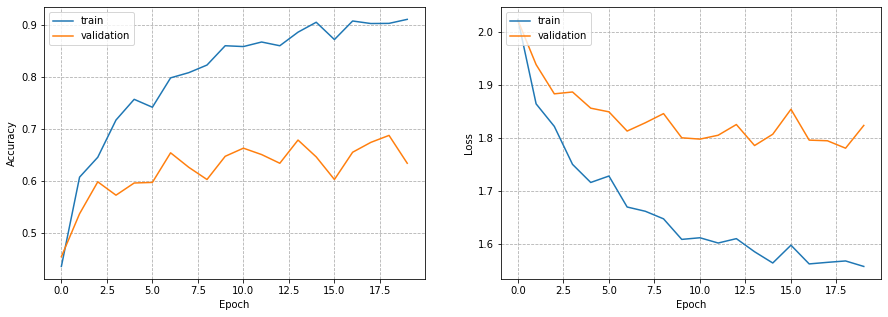

	Max validation accuracy: 68.7500 %
	Min validation loss: 1.78069


In [ ]:
# TRAINING THE SYSTEM

# training configuration
epochs = 20
batch_size = 32
num_of_workers = 0

# model configuration
hidden_size_rnn = 64
num_layers_rnn = 2
num_classes = 10

# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

# init model
model = CNN_RNN(hidden_size_rnn, num_layers_rnn, num_classes, device).to(device)
  
# init train data loader
train_ds = UrbanSound8kDataset(train_df_norm, transform=train_transforms)
train_loader = DataLoader(train_ds, 
                          batch_size = batch_size,
                          shuffle = True,
                          pin_memory = True,
                          num_workers = num_of_workers)

# init valid data loader
val_ds = UrbanSound8kDataset(val_df_norm, transform=test_transforms)
val_loader = DataLoader(val_ds, 
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# train the model
start_time = datetime.now()
history = model.fit(train_loader, epochs=epochs, val_loader=val_loader)
end_time = datetime.now() - start_time
print("\nTraining completed in time: {}".format(end_time))

# show the results
show_results(history)


Llegamos a uno valor de accuracy del 69% en validation (y de un 92% aproximadamente en entrenamiento).

In [ ]:
# TESTING THE SYSTEM

# init test data loader
test_ds = UrbanSound8kDataset(test_df_norm, transform=test_transforms)
test_loader = DataLoader(test_ds, 
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# Test accuracy
score = model.evaluate(test_loader)
print("Test accuracy: %.4f%%" % (100 * score[1]))


Test accuracy: 65.9598%


<ipython-input-49-649ec3c71be2>:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


El accuracy en test se aproxima al 66%.

---
### **[EXERCISE 2]**
---
After analyzing the architecture of the CNN-RNN model and the previous cell code, answer the following questions:

1. Explain the dimensions of the data at the output of the last CNN layer.

A la entrada de la CNN tenemos batches de 32 imágenes de 1x128x128 por lo que contamos con una entrada de 32x1x128x128

Aplicando los cálculos relevantes, tendremos:

  - A la salida de la capa convs1: Vector de 27x32x31x31
  - A la salida de la capa convs2: Vector de 27x64x7x7
  - A la salida de la capa convs3: Vector de 27x64x2x5



2. Why does the output of the "Many-to-One" step produce a 2-dimensional vector?

Para cada una de las muestras del batch, solo tomamos el último paso temporal de las mismas como entrada a la capa lineal. De esta manera x = x[:,-1] toma (usando ":") TODAS las muestras del batch y con -1 selecciona el último elemento en la dimension temporal



3. What is the role of the softmax activation function?

Su función es establecer todas las salidas (las 10) como una distribución de probabilidad que deben sumar 1 de tal manera que la clase con mayor valor estará referenciada a la clase más probable dado el audio de entrada, siendo esta, su etiqueta.


---
### **[EXERCISE 3]**
---
           
1.  Modify the "Many-to-One" step of the CNN-RNN architecture for incorporating a Mean-Pooling mechanism. The function **avg_pool1d** from *Pytorch* can be used for this purpose.

2. Train and test the system with this modification. Does the model performance
improve by using the Mean-Pooling mechanism? Why do you think this happens?

In [ ]:
# 1 Modify the "Many-to-One" step of the CNN-RNN architecture for incorporating a Mean-Pooling mechanism. The function **avg_pool1d** from *Pytorch* can be used for this purpose.

class CNN_RNN(nn.Module):
    def __init__(self, hidden_size_rnn, num_layers_rnn, num_classes, device):
        super(CNN_RNN, self).__init__()

        self.convs1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )
        
        self.convs3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0),
            nn.Dropout(p=0.1)
        )
 
        self.recur = nn.LSTM(128, hidden_size_rnn, num_layers=num_layers_rnn, batch_first=True)

        self.dense = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(hidden_size_rnn, eps=1e-05, momentum=0.1),
            nn.Linear(in_features=hidden_size_rnn, out_features=num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):

        # input x -> (batch, channel, freq, time)

        # cnn layer-1
        x = self.convs1(x)
        # cnn layer-2
        x = self.convs2(x)
        # cnn layer-3
        x = self.convs3(x)
        # x -> (batch, channel, freq, time)
        # transpose channel and time
        x = x.transpose(1, 3)
        # YOUR CODE HERE!!! THINK ABOUT THIS, AN LSTM WORKS IN TIME NOT CHANNELS!!!
        # x -> (batch, time, freq, channel)
        
        # collapse height and channel!!! AN LSTM EXPECTS TWO DIMENSIONS, TIME AND FEATURES
        x = x.reshape(x.size(0), x.size(1), -1)
        # xt -> (batch, time, freq*channel)

        # rnn layer 
        x, _ = self.recur(x)
        # x -> (batch, time, lstm_out)
        
        x = x.reshape(x.size(0), x.size(2), x.size(1))
        # x -> (batch, lstm_out, time)

        # mean-pooling
        x = F.avg_pool1d(x, kernel_size=3)
        # x -> (batch, lstm_out, time)

        # transform x back to (batch, time, lstm_out)
        x = x.reshape(x.size(0), x.size(2), x.size(1))
        # x -> (batch, time, lstm_out)

        # many-to-one rnn!! We are going to only use the last time step of the rnn_layer to predict the sound
        x = x[:,-1]
        # x -> (batch, lstm_out)

        # dense output layer
        x = self.dense(x)
        # x -> (batch, num_classes)

        # Softmax activation!!!
        x = F.softmax(x)
        # x -> (batch, num_classes)
        
        return x
    
    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step() 

                    pbar.update(1)        
            
            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
        return history

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)
        self.eval()

        with torch.no_grad():
            for step, batch in enumerate(data_loader):
                X_batch = batch['spectrogram'].to(self.device)
                y_batch = batch['label'].to(self.device)
            
                outputs = self.forward(X_batch)

                # get batch loss
                loss = self.criterion(outputs, y_batch)
                running_loss = running_loss + loss

                # calculate batch accuracy
                predictions = torch.argmax(outputs, dim=1) 
                correct_predictions = (predictions == y_batch).float().sum()
                running_acc = running_acc + torch.div(correct_predictions, batch_size)
            
            loss = running_loss.item() / (step+1)
            accuracy = running_acc.item() / (step+1)
        
        return loss, accuracy

In [ ]:
# 2. Train and test the system with this modification. Does the model performance improve by using the Mean-Pooling mechanism? Why do you think this happens?


Epoch 1/20
  2%|▏         | 4/218 [00:00<00:06, 33.02it/s]

<ipython-input-35-2e2cf05272d4>:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


100%|██████████| 218/218 [00:06<00:00, 33.75it/s]
loss: 1.9274 - accuracy: 0.5603 - val_loss: 1.9759 - val_accuracy: 0.4799

Epoch 2/20
100%|██████████| 218/218 [00:10<00:00, 20.66it/s]
loss: 1.8288 - accuracy: 0.6499 - val_loss: 1.9021 - val_accuracy: 0.5837

Epoch 3/20
100%|██████████| 218/218 [00:08<00:00, 26.18it/s]
loss: 1.7834 - accuracy: 0.6917 - val_loss: 1.8451 - val_accuracy: 0.6250

Epoch 4/20
100%|██████████| 218/218 [00:07<00:00, 30.55it/s]
loss: 1.7286 - accuracy: 0.7414 - val_loss: 1.8687 - val_accuracy: 0.5826

Epoch 5/20
100%|██████████| 218/218 [00:06<00:00, 34.11it/s]
loss: 1.7304 - accuracy: 0.7464 - val_loss: 1.8299 - val_accuracy: 0.6217

Epoch 6/20
100%|██████████| 218/218 [00:06<00:00, 31.29it/s]
loss: 1.6603 - accuracy: 0.8121 - val_loss: 1.7834 - val_accuracy: 0.6730

Epoch 7/20
100%|██████████| 218/218 [00:08<00:00, 25.25it/s]
loss: 1.6576 - accuracy: 0.8159 - val_loss: 1.7790 - val_accuracy: 0.6752

Epoch 8/20
100%|██████████| 218/218 [00:09<00:00, 23.05it/s

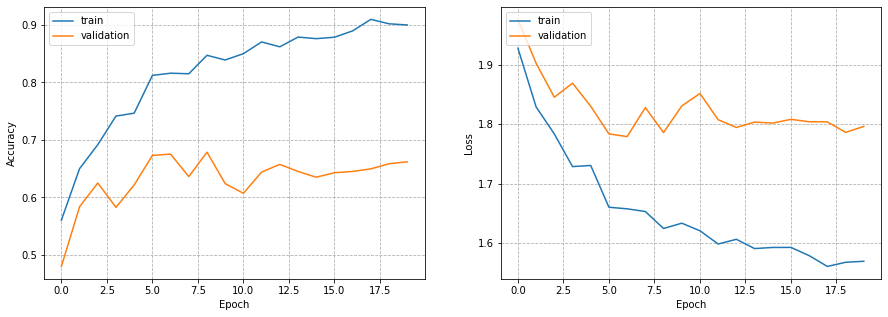

	Max validation accuracy: 67.8571 %
	Min validation loss: 1.77898


In [ ]:
# TRAINING THE SYSTEM

# training configuration
epochs = 20
batch_size = 32
num_of_workers = 0

# model configuration
hidden_size_rnn = 64
num_layers_rnn = 2
num_classes = 10

# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

# init model
model = CNN_RNN(hidden_size_rnn, num_layers_rnn, num_classes, device).to(device)
  
# init train data loader
train_ds = UrbanSound8kDataset(train_df_norm, transform=train_transforms)
train_loader = DataLoader(train_ds, 
                          batch_size = batch_size,
                          shuffle = True,
                          pin_memory = True,
                          num_workers = num_of_workers)

# init valid data loader
val_ds = UrbanSound8kDataset(val_df_norm, transform=test_transforms)
val_loader = DataLoader(val_ds, 
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# train the model
start_time = datetime.now()
history = model.fit(train_loader, epochs=epochs, val_loader=val_loader)
end_time = datetime.now() - start_time
print("\nTraining completed in time: {}".format(end_time))

# show the results
show_results(history)

LLegamos a uno valor de accuracy del 69% en validation (y de un 92% aproximadamente en entrenamiento).

In [ ]:
# TESTING THE SYSTEM

# init test data loader
test_ds = UrbanSound8kDataset(test_df_norm, transform=test_transforms)
test_loader = DataLoader(test_ds, 
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# Test accuracy
score = model.evaluate(test_loader)
print("Test accuracy: %.4f%%" % (100 * score[1]))

Test accuracy: 66.5179%


<ipython-input-35-2e2cf05272d4>:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


El accuracy en test se aproxima al 66%.

El modelo mejora levemente, esto puede ser por diferentes motivos gracias al mean-pooling:

Reducción del ruido: el Mean-Pooling permite promediar varias observaciones juntas, lo que puede ayudar a reducir el ruido y la variabilidad en los datos. Esto puede mejorar la estabilidad del modelo.

Al promediar varias observaciones, el Mean-Pooling también puede ayudar a suavizar y regularizar los datos, lo que puede mejorar la capacidad del modelo para generalizar a conjuntos de datos no vistos.

Mejora de la convergencia del modelo sin necesidad de encontrar los mejores hiperparámetros.

Cabe destacar que contamos con un tiempo de ejecución similar al caso anterior.

---
### **[EXERCISE 4]**
---
           
1.  In some occassions, it is possible to get an extra boost in performance by allowing the recursive layer to use both, past and future samples for the present predictions. Take a look at the "bidirectional" option in the LSTM layer, and change your code to use it.

2. Train and test the system with this modification. Does the model performance
improve by using bidirectional LSTMs?

> HINT: Bidirectional recursive layers in Pytorch are implemented as two individual layers, each of them looking at the input data in reverse order from each other. Both individual outputs are concatenated into a final tensor. Thus, the dimension of the output gets doubled with respect to a non bidirectional LSTM. Note this fact has influence on the input size of the next dense layer.



In [ ]:
# 1.  In some occassions, it is possible to get an extra boost in performance by allowing the recursive layer to use both, past and future samples for the present predictions. Take a look at the "bidirectional" option in the LSTM layer, and change your code to use it.

In [ ]:
# CNN-RNN MODEL

class CNN_RNN(nn.Module):
    def __init__(self, hidden_size_rnn, num_layers_rnn, num_classes, device):
        super(CNN_RNN, self).__init__()

        self.convs1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )
        
        self.convs3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0),
            nn.Dropout(p=0.1)
        )
 
        self.recur_fwd = nn.LSTM(128, hidden_size_rnn, num_layers=num_layers_rnn, batch_first=False)
        self.recur_bwd = nn.LSTM(128, hidden_size_rnn, num_layers=num_layers_rnn, batch_first=False)

        self.dense = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(hidden_size_rnn * 2, eps=1e-05, momentum=0.1),
            nn.Linear(in_features=hidden_size_rnn * 2, out_features=num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):

        # input x -> (batch, channel, freq, time)

        # cnn layer-1
        x = self.convs1(x)
        # cnn layer-2
        x = self.convs2(x)
        # cnn layer-3
        x = self.convs3(x)
        # x -> (batch, channel, freq, time)
        # transpose channel and time
        x = x.transpose(1, 3)
        # YOUR CODE HERE!!! THINK ABOUT THIS, AN LSTM WORKS IN TIME NOT CHANNELS!!!
        # x -> (batch, time, freq, channel)
        
        # collapse height and channel!!! AN LSTM EXPECTS TWO DIMENSIONS, TIME AND FEATURES
        x = x.reshape(x.size(0), x.size(1), -1)
        # xt -> (batch, time, freq*channel)

        # LSTM mirando los datos en el orden normal
        x_fwd, _ = self.recur_fwd(x)
        # LSTM mirando los datos en orden inverso (empezamos por el final del batch)
        x_bwd, _ = self.recur_bwd(torch.flip(x, [0]))

        # concatenate forward and backward passes
        x = torch.cat([x_fwd, x_bwd], dim=-1)
        
        # many-to-one rnn!! We are going to only use the last time step of the rnn_layer to predict the sound
        x = x[:,-1]
        # x -> (batch, lstm_out)

        # dense output layer
        x = self.dense(x)
        # x -> (batch, num_classes)

        # Softmax activation!!!
        x = F.softmax(x)
        # x -> (batch, num_classes)
        
        return x
    
    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step() 

                    pbar.update(1)        
            
            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
        return history

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)
        self.eval()

        with torch.no_grad():
            for step, batch in enumerate(data_loader):
                X_batch = batch['spectrogram'].to(self.device)
                y_batch = batch['label'].to(self.device)
            
                outputs = self.forward(X_batch)

                # get batch loss
                loss = self.criterion(outputs, y_batch)
                running_loss = running_loss + loss

                # calculate batch accuracy
                predictions = torch.argmax(outputs, dim=1) 
                correct_predictions = (predictions == y_batch).float().sum()
                running_acc = running_acc + torch.div(correct_predictions, batch_size)
            
            loss = running_loss.item() / (step+1)
            accuracy = running_acc.item() / (step+1)
        
        return loss, accuracy


In [ ]:
#2. Train and test the system with this modification. Does the model performance improve by using bidirectional LSTMs?


Epoch 1/20
  0%|          | 0/218 [00:00<?, ?it/s]

<ipython-input-25-64a40070d2a9>:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


100%|██████████| 218/218 [01:30<00:00,  2.42it/s]
loss: 2.1767 - accuracy: 0.2768 - val_loss: 2.1486 - val_accuracy: 0.2667

Epoch 2/20
100%|██████████| 218/218 [01:32<00:00,  2.36it/s]
loss: 2.0271 - accuracy: 0.4365 - val_loss: 2.0984 - val_accuracy: 0.3270

Epoch 3/20
100%|██████████| 218/218 [01:40<00:00,  2.17it/s]
loss: 1.9700 - accuracy: 0.5020 - val_loss: 2.0188 - val_accuracy: 0.4487

Epoch 4/20
100%|██████████| 218/218 [01:32<00:00,  2.36it/s]
loss: 1.9217 - accuracy: 0.5456 - val_loss: 1.9819 - val_accuracy: 0.4632

Epoch 5/20
100%|██████████| 218/218 [01:32<00:00,  2.35it/s]
loss: 1.8523 - accuracy: 0.6191 - val_loss: 1.9186 - val_accuracy: 0.5379

Epoch 6/20
100%|██████████| 218/218 [01:37<00:00,  2.24it/s]
loss: 1.8296 - accuracy: 0.6319 - val_loss: 1.9421 - val_accuracy: 0.5201

Epoch 7/20
100%|██████████| 218/218 [01:34<00:00,  2.31it/s]
loss: 1.8235 - accuracy: 0.6462 - val_loss: 1.9553 - val_accuracy: 0.5134

Epoch 8/20
100%|██████████| 218/218 [01:32<00:00,  2.35it/s

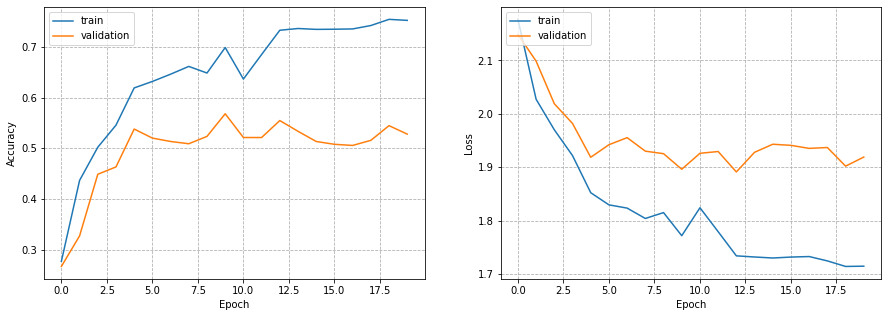

	Max validation accuracy: 56.8080 %
	Min validation loss: 1.89119


In [ ]:
# TRAINING THE SYSTEM

# training configuration
epochs = 20
batch_size = 32
num_of_workers = 0

# model configuration
hidden_size_rnn = 64
num_layers_rnn = 2
num_classes = 10

# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:                                              
  device = torch.device("cpu")

# init model
model = CNN_RNN(hidden_size_rnn, num_layers_rnn, num_classes, device).to(device)
  
# init train data loader
train_ds = UrbanSound8kDataset(train_df_norm, transform=train_transforms)
train_loader = DataLoader(train_ds, 
                          batch_size = batch_size,
                          shuffle = True,
                          pin_memory = True,
                          num_workers = num_of_workers)

# init valid data loader
val_ds = UrbanSound8kDataset(val_df_norm, transform=test_transforms)
val_loader = DataLoader(val_ds, 
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# train the model
start_time = datetime.now()
history = model.fit(train_loader, epochs=epochs, val_loader=val_loader)
end_time = datetime.now() - start_time
print("\nTraining completed in time: {}".format(end_time))

# show the results
show_results(history)

In [ ]:
# TESTING THE SYSTEM

# init test data loader
test_ds = UrbanSound8kDataset(test_df_norm, transform=test_transforms)
test_loader = DataLoader(test_ds, 
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# Test accuracy
score = model.evaluate(test_loader)
print("Test accuracy: %.4f%%" % (100 * score[1]))

<ipython-input-25-64a40070d2a9>:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Test accuracy: 63.8393%


Veamos porque empeora levemente (un 2% de accuracy) el rendimiento al añadir la LSTM bidireccional:

Un clasificador de audio formado por una CNN y una LSTM puede mejorar su rendimiento al añadir una LSTM bidireccional en algunos casos, pero también puede empeorarlo en otros dependiendo, como siempre, de diversos factores, como la complejidad del problema de clasificación, la calidad y cantidad de datos de entrenamiento disponibles y la arquitectura del modelo.

Como sabemos, añadir una LSTM bidireccional puede mejorar el rendimiento si el problema de clasificación es complejo y requiere de un análisis detallado de las dependencias en la secuencia de audio tanto en el pasado como en el futuro. Sin embargo, si el problema es relativamente simple y la LSTM normal es suficiente para captar las dependencias relevantes en la secuencia, añadir una LSTM bidireccional podría hacer que el modelo sea más complejo de lo necesario y empeorar el rendimiento, lo que probablemente, sea este caso.

Destacamos un coste computacional de 46mn, bruscamente superior a los casos anteriores.